# TensorFlow 선형회귀 실습: 보스턴 주택가격 데이터

이번 실습에서는 보스턴 주택가격 데이터를 활용하여 선형회귀를 적용해봅니다.




## StandardScaler를 사용하지 않을 때 발생하는 문제들

실제 데이터로 정규화의 중요성을 확인해보겠습니다.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
california = fetch_california_housing()
X = california.data
y = california.target

print("=== 데이터 스케일 분석 ===")
feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 
                'Population', 'AveOccup', 'Latitude', 'Longitude']

print("원본 데이터 통계:")
for i, name in enumerate(feature_names):
    print(f"{name:12}: 평균={X[:, i].mean():8.3f}, 표준편차={X[:, i].std():8.3f}, 범위=[{X[:, i].min():6.3f}, {X[:, i].max():6.3f}]")

# 스케일 차이 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot([X[:, i] for i in range(8)], labels=feature_names)
plt.title('정규화 전 - 특성별 스케일')
plt.xticks(rotation=45)
plt.ylabel('값의 범위')

# StandardScaler 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.subplot(1, 2, 2)
plt.boxplot([X_scaled[:, i] for i in range(8)], labels=feature_names)
plt.title('정규화 후 - 특성별 스케일')
plt.xticks(rotation=45)
plt.ylabel('정규화된 값')

plt.tight_layout()
plt.show()

print(f"\n정규화 후 통계:")
for i, name in enumerate(feature_names):
    print(f"{name:12}: 평균={X_scaled[:, i].mean():8.3f}, 표준편차={X_scaled[:, i].std():8.3f}, 범위=[{X_scaled[:, i].min():6.3f}, {X_scaled[:, i].max():6.3f}]")


In [ ]:
# 문제 1: 학습 불안정성 비교
print("=== 문제 1: 학습 불안정성 비교 ===")

# 정규화 없는 모델
model_raw = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(8,)),
    tf.keras.layers.Dense(1)
])

model_raw.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01),
                 loss='mse')

# 정규화된 모델
model_scaled = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(8,)),
    tf.keras.layers.Dense(1)
])

model_scaled.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01),
                    loss='mse')

# 학습
print("정규화 없는 모델 학습 중...")
history_raw = model_raw.fit(X, y, epochs=100, verbose=0)

print("정규화된 모델 학습 중...")
history_scaled = model_scaled.fit(X_scaled, y, epochs=100, verbose=0)

# 학습 곡선 비교
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_raw.history['loss'], label='정규화 없음', color='red')
plt.plot(history_scaled.history['loss'], label='정규화 있음', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('학습 곡선 비교')
plt.legend()
plt.grid(True, alpha=0.3)

# 가중치 비교
weights_raw = model_raw.get_weights()[0].flatten()
weights_scaled = model_scaled.get_weights()[0].flatten()

plt.subplot(1, 3, 2)
plt.bar(range(len(weights_raw)), weights_raw, alpha=0.7, label='정규화 없음', color='red')
plt.xlabel('특성 인덱스')
plt.ylabel('가중치 크기')
plt.title('가중치 크기 비교')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.bar(range(len(weights_scaled)), weights_scaled, alpha=0.7, label='정규화 있음', color='blue')
plt.xlabel('특성 인덱스')
plt.ylabel('가중치 크기')
plt.title('정규화된 가중치')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"정규화 없는 모델 최종 손실: {history_raw.history['loss'][-1]:.4f}")
print(f"정규화된 모델 최종 손실: {history_scaled.history['loss'][-1]:.4f}")
print(f"가중치 크기 차이: {np.abs(weights_raw).max() / np.abs(weights_scaled).max():.2f}배")


In [ ]:
# 문제 2: 특성 불공정성 (Feature Bias)
print("=== 문제 2: 특성 불공정성 ===")

# 각 특성이 예측에 미치는 영향 분석
def analyze_feature_importance(model, X_data, feature_names, title):
    weights = model.get_weights()[0].flatten()
    
    # 원본 데이터의 표준편차로 가중치 조정
    feature_std = X_data.std(axis=0)
    adjusted_weights = weights * feature_std
    
    print(f"\n{title}:")
    print("특성별 실제 영향도 (가중치 × 표준편차):")
    for i, (name, impact) in enumerate(zip(feature_names, adjusted_weights)):
        print(f"{name:12}: {impact:8.3f}")
    
    return adjusted_weights

# 정규화 없는 모델의 특성 영향도
impact_raw = analyze_feature_importance(model_raw, X, feature_names, "정규화 없는 모델")

# 정규화된 모델의 특성 영향도  
impact_scaled = analyze_feature_importance(model_scaled, X_scaled, feature_names, "정규화된 모델")

# 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(feature_names, impact_raw, color='red', alpha=0.7)
plt.title('정규화 없음 - 특성 영향도')
plt.xticks(rotation=45)
plt.ylabel('실제 영향도')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.bar(feature_names, impact_scaled, color='blue', alpha=0.7)
plt.title('정규화 있음 - 특성 영향도')
plt.xticks(rotation=45)
plt.ylabel('실제 영향도')
plt.grid(True, alpha=0.3)

# 영향도 차이
plt.subplot(1, 3, 3)
impact_diff = np.abs(impact_raw) - np.abs(impact_scaled)
colors = ['red' if x > 0 else 'blue' for x in impact_diff]
plt.bar(feature_names, impact_diff, color=colors, alpha=0.7)
plt.title('영향도 차이 (빨강: 정규화 없음이 더 큰 영향)')
plt.xticks(rotation=45)
plt.ylabel('영향도 차이')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n특성 영향도 불균형 지수:")
print(f"정규화 없음: {np.std(impact_raw):.3f}")
print(f"정규화 있음: {np.std(impact_scaled):.3f}")
print(f"개선도: {np.std(impact_raw) / np.std(impact_scaled):.2f}배 더 균등")


In [ ]:
# 문제 3: 수치적 불안정성 (NaN 발생)
print("=== 문제 3: 수치적 불안정성 ===")

# 극단적인 학습률로 테스트
learning_rates = [0.001, 0.01, 0.1, 1.0]
results = []

for lr in learning_rates:
    print(f"\n학습률 {lr} 테스트:")
    
    # 정규화 없는 모델
    model_test = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(8,)),
        tf.keras.layers.Dense(1)
    ])
    
    model_test.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=lr),
                      loss='mse')
    
    try:
        history = model_test.fit(X, y, epochs=50, verbose=0)
        final_loss = history.history['loss'][-1]
        has_nan = np.isnan(final_loss) or np.isinf(final_loss)
        print(f"  정규화 없음: 손실={final_loss:.4f}, NaN={has_nan}")
    except Exception as e:
        print(f"  정규화 없음: 오류 발생 - {str(e)[:50]}...")
        final_loss = float('inf')
        has_nan = True
    
    # 정규화된 모델
    model_test_scaled = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(8,)),
        tf.keras.layers.Dense(1)
    ])
    
    model_test_scaled.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=lr),
                             loss='mse')
    
    try:
        history_scaled = model_test_scaled.fit(X_scaled, y, epochs=50, verbose=0)
        final_loss_scaled = history_scaled.history['loss'][-1]
        has_nan_scaled = np.isnan(final_loss_scaled) or np.isinf(final_loss_scaled)
        print(f"  정규화 있음: 손실={final_loss_scaled:.4f}, NaN={has_nan_scaled}")
    except Exception as e:
        print(f"  정규화 있음: 오류 발생 - {str(e)[:50]}...")
        final_loss_scaled = float('inf')
        has_nan_scaled = True
    
    results.append({
        'lr': lr,
        'raw_loss': final_loss,
        'raw_nan': has_nan,
        'scaled_loss': final_loss_scaled,
        'scaled_nan': has_nan_scaled
    })

# 결과 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
lrs = [r['lr'] for r in results]
raw_losses = [r['raw_loss'] if not r['raw_nan'] else None for r in results]
scaled_losses = [r['scaled_loss'] if not r['scaled_nan'] else None for r in results]

plt.plot(lrs, raw_losses, 'ro-', label='정규화 없음', markersize=8)
plt.plot(lrs, scaled_losses, 'bo-', label='정규화 있음', markersize=8)
plt.xlabel('학습률')
plt.ylabel('최종 손실')
plt.title('학습률별 안정성 비교')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
raw_nan_count = sum(1 for r in results if r['raw_nan'])
scaled_nan_count = sum(1 for r in results if r['scaled_nan'])

plt.bar(['정규화 없음', '정규화 있음'], [raw_nan_count, scaled_nan_count], 
        color=['red', 'blue'], alpha=0.7)
plt.ylabel('NaN 발생 횟수')
plt.title('수치적 불안정성 비교')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nNaN 발생 요약:")
print(f"정규화 없음: {raw_nan_count}/{len(learning_rates)}회")
print(f"정규화 있음: {scaled_nan_count}/{len(learning_rates)}회")


## StandardScaler를 사용하지 않을 때 발생하는 문제들 요약

### 1. **학습 불안정성**
- **문제**: 특성 간 스케일 차이로 인한 불균등한 학습
- **증상**: 학습 곡선이 불안정하거나 발산
- **원인**: 큰 값의 특성이 그래디언트를 지배

### 2. **특성 불공정성 (Feature Bias)**
- **문제**: 스케일이 큰 특성이 모델을 지배
- **증상**: 중요한 특성이 무시되고 부수적인 특성이 과도하게 영향
- **예시**: Population(인구수)이 MedInc(소득)보다 큰 영향

### 3. **수치적 불안정성**
- **문제**: NaN(Not a Number) 또는 무한대 값 발생
- **증상**: 학습 중 오류 발생 또는 예측 불가
- **원인**: 극단적인 가중치 값으로 인한 오버플로우

### 4. **성능 저하**
- **문제**: 수렴 속도 저하 및 최종 성능 감소
- **증상**: 더 많은 에포크 필요, 낮은 정확도
- **원인**: 비효율적인 최적화 과정

### 5. **알고리즘별 민감도**
- **선형 모델**: 매우 민감 (가중치에 직접 영향)
- **신경망**: 중간 정도 민감 (활성화 함수 입력)
- **거리 기반**: 매우 민감 (유클리드 거리 계산)

### 6. **해결 방법**
- **StandardScaler**: 평균 0, 표준편차 1로 정규화
- **MinMaxScaler**: 0-1 범위로 스케일링
- **RobustScaler**: 이상치에 강한 정규화


## Dataset 설명
- California Housing Dataset은 캘리포니아 주의 주택 가격과 관련된 다양한 특성들을 포함하고 있습니다.
- 이 데이터셋은 주택 가격 예측과 관련된 머신러닝 모델을 개발하는 데 자주 사용됩니다.
- 데이터셋은 8개의 특성과 1개의 타겟 변수로 구성되어 있습니다.

### 특성 설명:
- MedHouseValue (target): 주택 가격 (단위: 10만 달러)
- MedInc: 중간 소득 (단위: 10,000 달러)
- HouseAge: 주택 연령 (단위: 년)
- AveRooms: 평균 방 개수
- AveBedrms: 평균 침실 개수
- Population: 인구 수
- AveOccup: 평균 가구원 수
- Latitude: 위도
- Longitude: 경도

## 실습 목표
1. 데이터 불러오기 및 전처리
2. 데이터 시각화
3. TensorFlow를 활용한 선형회귀 모델 정의 및 학습
4. 결과 해석 및 시각화

In [ ]:
# matplotlib 폰트 깨짐 현상 해결
import matplotlib.font_manager as fm
fm.fontManager.ttflist
[f.name for f in fm.fontManager.ttflist]

import matplotlib as mpl
mpl.rcParams['font.family'] = 'NanumGothic'

## 문제 1. 데이터 불러오기

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ----------------------
# 1. 데이터 불러오기
# ----------------------
california = fetch_california_housing()
print(california.data.shape)
X = california.data         # Attributes (8개 특성)
y = california.target       # Target (주택가격)
feature_names = california.feature_names

print("X shape:", X.shape, "y shape:", y.shape)

(20640, 8)
X shape: (20640, 8) y shape: (20640,)


## 문제 2. 데이터 시각화

C:\Users\kimyo\AppData\Local\Temp\ipykernel_19832\4242818372.py:10: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()


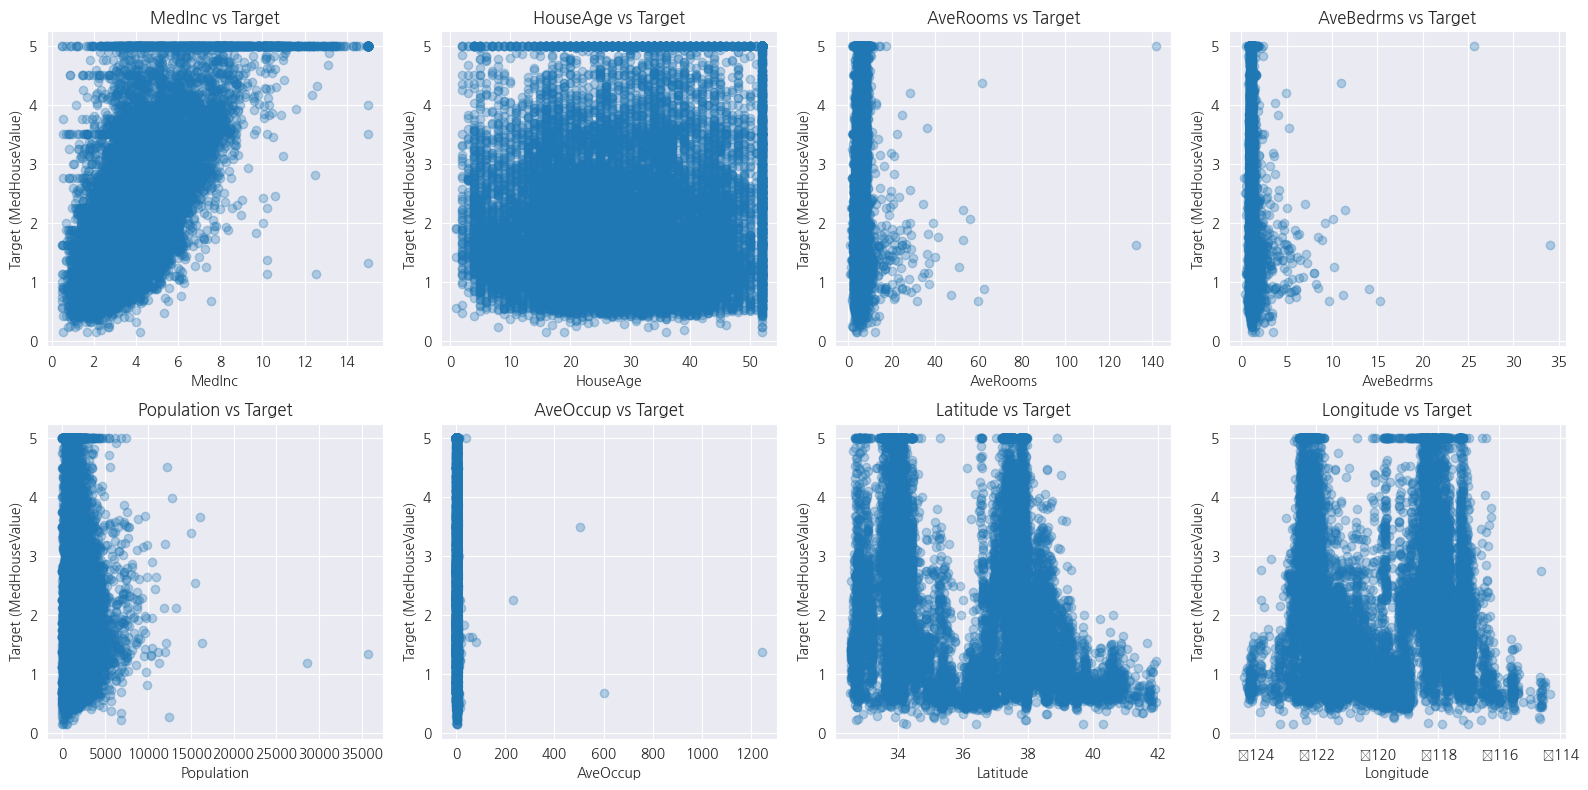

In [ ]:
plt.figure(figsize=(16, 8))

for i in range(8):
    plt.subplot(2, 4, i+1)  # 2행 4열 subplot
    plt.scatter(X[:, i], y, alpha=0.3)
    plt.xlabel(feature_names[i])
    plt.ylabel("Target (MedHouseValue)")
    plt.title(f"{feature_names[i]} vs Target")

plt.tight_layout()
plt.show()

## 문제 3. 데이터 전처리

In [ ]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 표준화 (정규화)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 타깃 차원 맞추기
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("훈련 데이터 shape:", X_train.shape, y_train.shape)
print("테스트 데이터 shape:", X_test.shape, y_test.shape)

훈련 데이터 shape: (16512, 8) (16512, 1)
훈련 데이터 shape: (4128, 8) (4128, 1)


## 문제 4. 모델 정의 및 학습

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
516/516 - 1s - 1ms/step - loss: 2.3630 - val_loss: 0.5588
Epoch 2/50
516/516 - 0s - 884us/step - loss: 1.0308 - val_loss: 0.5450
Epoch 3/50
516/516 - 0s - 881us/step - loss: 0.7937 - val_loss: 0.5561
Epoch 4/50
516/516 - 0s - 874us/step - loss: 0.6286 - val_loss: 0.5718
Epoch 5/50
516/516 - 0s - 877us/step - loss: 0.5639 - val_loss: 0.5451
Epoch 6/50
516/516 - 0s - 871us/step - loss: 0.5315 - val_loss: 0.5452
Epoch 7/50
516/516 - 0s - 876us/step - loss: 0.5314 - val_loss: 0.5539
Epoch 8/50
516/516 - 0s - 861us/step - loss: 0.5238 - val_loss: 0.5517
Epoch 9/50
516/516 - 0s - 861us/step - loss: 0.5267 - val_loss: 0.5481
Epoch 10/50
516/516 - 0s - 885us/step - loss: 0.5232 - val_loss: 0.5606
Epoch 11/50
516/516 - 0s - 859us/step - loss: 0.5231 - val_loss: 0.5733
Epoch 12/50
516/516 - 0s - 848us/step - loss: 0.5354 - val_loss: 0.5857
Epoch 13/50
516/516 - 0s - 871us/step - loss: 0.5249 - val_loss: 0.5470
Epoch 14/50
516/516 - 0s - 856us/step - loss: 0.5251 - val_loss: 0.5526
Epo

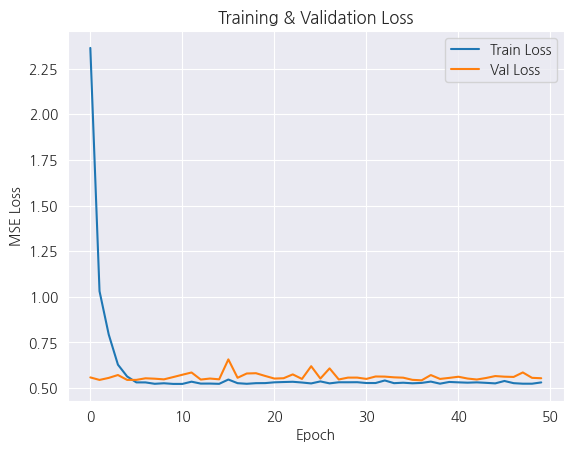

In [ ]:
## 2. 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(8,)),
    tf.keras.layers.Dense(1)
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='mse')

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    verbose=2)

plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

## 문제 4. 학습 결과 확인

학습된 가중치(W) shape: (8, 1)
학습된 절편(b): [2.013267]
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


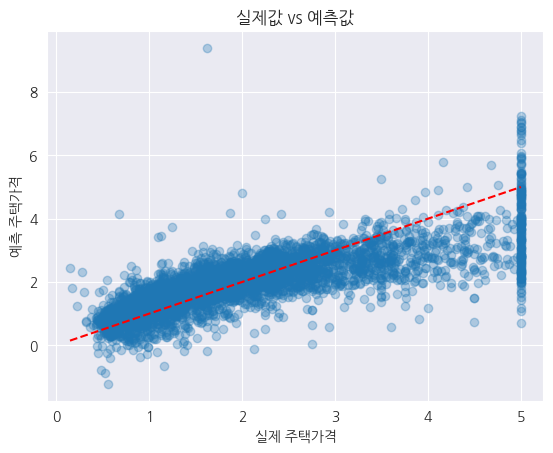

In [ ]:
# ----------------------
# 7. 결과 확인
# ----------------------
W, b = model.layers[0].get_weights()
print("학습된 가중치(W) shape:", W.shape)
print("학습된 절편(b):", b)

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 산점도 (실제 vs 예측)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("실제 주택가격")
plt.ylabel("예측 주택가격")
plt.title("실제값 vs 예측값")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')  # y=x 기준선
plt.show()

## 생각해보기
- Scaler를 사용하지 않으면 어떻게 되는가?

각각 input의 사이즈의 범위가 달라서 메모리를 넘어서서 값이 계산이 안되거나, 학습곡선이 불안정함